


# <font color='red'>**Sequence to sequence implementation**</font>

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [ ]:
!wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8,hi;q=0.7" --header="Cookie: __utma=3028652.1607358814.1634216631.1634216631.1634216631.1; __utmz=3028652.1634216631.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none)" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'

--2022-08-27 14:14:49--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7782544 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.42M  19.4MB/s    in 0.4s    

2022-08-27 14:14:49 (19.4 MB/s) - ‘ita-eng.zip’ saved [7782544/7782544]



In [ ]:
!unzip ita-eng.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

<font color='blue'>**Preprocess data**</font>

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(354238, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 22 for italian sentences and  &lt; 25 for english sentences  </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 22]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 25]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
306085,non cè nessuna possibilità che lui si riprenderà,<start> there is no chance that he will recover,there is no chance that he will recover <end>
279836,cercai il libro per unora,<start> i looked for the book for an hour,i looked for the book for an hour <end>
13943,io sono devota,<start> i am committed,i am committed <end>
127274,tom è vivo vero,<start> tom is alive is not he,tom is alive is not he <end>
245448,pensavo che noi fossimo le benvenute qui,<start> i thought we were welcome here,i thought we were welcome here <end>
353318,in questo corso passeremo del tempo aiutandola...,<start> in this course we will spend time help...,in this course we will spend time helping you ...
228681,siete mai stati in america,<start> have you ever been to america,have you ever been to america <end>
338075,tom non lo sapeva che mary si stava vedendo co...,<start> tom did not know mary was seeing someo...,tom did not know mary was seeing someone else ...
235757,tom ha consigliato a mary di non farla,<start> tom advised mary not to do it,tom advised mary not to do it <end>
273349,tom non vuole lasciare boston,<start> tom does not want to leave boston,tom does not want to leave boston <end>


### Getting train and test 


In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2 , random_state = 1)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(283068, 3) (70767, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
122627,ci vedremo la settimana prossima,<start> i will see you next week <end>,i will see you next week <end> <end>
130538,chi le ha dato questo elenco,<start> who gave you this list,who gave you this list <end>
161415,dobbiamo andarcene da questo posto,<start> we must leave this place,we must leave this place <end>
207536,tom sta guardando un film ora,<start> tom is watching a movie now,tom is watching a movie now <end>
102547,non si scordi la borsa,<start> do not forget your bag,do not forget your bag <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
144180,tom rimase a casa per tutto il giorno,<start> tom stayed home all day,tom stayed home all day <end>
120500,io dovevo dire qualcosa,<start> i had to say something,i had to say something <end>
137797,voglio sbarazzarmene,<start> i want to get rid of it,i want to get rid of it <end>
78480,oggi cè molto caldo,<start> it is very hot today,it is very hot today <end>
320129,disse al suo assistente che avrebbe vinto,<start> he told his assistant that he would win,he told his assistant that he would win <end>


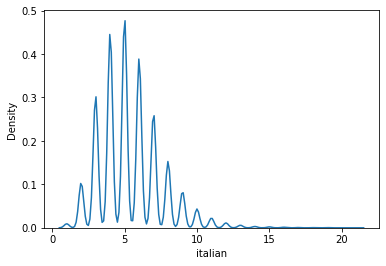

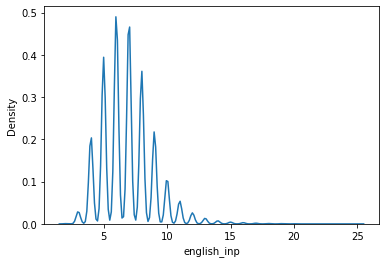

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13086
26775


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10327)

In [ ]:
tknizer_eng.index_word[2]
# tknizer_eng.index_word[0]                         # key error

'i'

### Creating embeddings for english sentences

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt


--2022-08-27 14:15:25--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-08-27 14:15:25--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfd3a094e8b680a2539779619f3.dl.dropboxusercontent.com/cd/0/inline/Bry8dzxtqE4BdgZVJgE1BEFsw0k03WJraVArucdQ57mOt6rrHZHuABIfIGp0EvHh8hZXAxzL_6iyLW66yDgFLW_zzFHZWO2CMqwQKC5YCWDPirpCOpOsH98YlwP3_ATO83EQZhGyhEmcGiAxic6CimJ4gcCCYDOb63qxDNmpzjcENg/file# [following]
--2022-08-27 14:15:25--  https://ucfd3a094e8b680a2539779619f3.dl.dropboxusercontent.com/cd/0/inline/Bry8dzxtqE4BdgZVJgE1BEFsw0k03WJraVArucdQ57mOt6rrHZHuA

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
tknizer_eng.word_index['<end>'] , tknizer_eng.word_index['<start>']

(10327, 1)

In [ ]:
embedding_matrix[10327]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
embedding_matrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
print(embedding_matrix.shape)
embedding_matrix[0]

(13087, 100)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,vocab_size,embedding_dim,enc_units,input_length):
      super().__init__()
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.enc_units = enc_units
      self.input_length = input_length
      self.encoder_outputs =0
      self.encoder_final_state_h = 0
      self.encoder_final_state_c = 0 

      #Initialize Embedding layer
      self.embedding = Embedding(input_dim=self.vocab_size , output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")    

      #Intialize Encoder LSTM layer
      self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sentence,states):
      input_embedd = self.embedding(input_sentence)
      self.encoder_outputs , self.encoder_final_state_h , self.encoder_final_state_c = self.lstm(input_embedd , initial_state = states)
      return self.encoder_outputs , self.encoder_final_state_h , self.encoder_final_state_c
      '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- encoder_output, last time step's hidden and cell state
      '''


      

    
    def initialize_states(self,batch_size):
      return tf.zeros([batch_size , self.enc_units]) , tf.zeros([batch_size , self.enc_units])
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.dec_vocab_size = out_vocab_size
      self.embedding_size = embedding_size
      self.lstm_size = lstm_size
      self.input_length = input_length
      self.decoder_outputs =0
      self.decoder_final_state_h = 0
      self.decoder_final_state_c = 0 

      #Initialize Embedding layer
      self.embedding = Embedding(input_dim=self.dec_vocab_size , output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder" ,weights=[embedding_matrix], trainable=False )   
    #   self.embedding = Embedding(input_dim=self.dec_vocab_size , output_dim=self.embedding_size, input_length=self.input_length,
                        #    mask_zero=True, name="embedding_layer_encoder"  )    

      #Intialize Decoder LSTM layer
      self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Decoder_LSTM")
      
    def call(self,input_sequence,initial_states):
      target_embedd = self.embedding(input_sequence)
      self.decoder_outputs , self.decoder_final_state_h , self.decoder_final_state_c = self.lstm(target_embedd , initial_state = initial_states)
      return self.decoder_outputs , self.decoder_final_state_h , self.decoder_final_state_c
      '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
      
        returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
      '''

      


<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(vocab_size = vocab_size_ita+1 ,embedding_dim =100 , enc_units = 100 ,input_length = encoder_inputs_length)        #  +1  is for  0 
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = vocab_size_eng + 1 ,embedding_size = 100,lstm_size = 100,input_length = decoder_inputs_length)

        self.dense=Dense(vocab_size_eng ,activation='softmax'  )
    

    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        enc_initial_states = self.encoder.initialize_states(1024)
        encoder_output, encoder_final_state_h,encoder_final_state_c = self.encoder(input , enc_initial_states)
        initial_states = [ encoder_final_state_h,encoder_final_state_c]
        decoder_output , _ , _  = self.decoder(output,initial_states)
        output  = self.dense(decoder_output)
        return output
        
        

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita , max_len_eng):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_ita = max_len_ita
        self.max_len_eng = max_len_eng

    def __getitem__(self, i):                                         
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])                 #  three things will be appended

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 22 , 25 )
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 22, 25)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 22) (1024, 25) (1024, 25)


In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model  = Encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=25)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min'  ,restore_best_weights = True 
)

In [ ]:
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps , callbacks = [earlystop])
model.summary()

Epoch 1/50
276/276 [==============================] - 67s 223ms/step - loss: 0.6251 - val_loss: 0.5936
Epoch 2/50
276/276 [==============================] - 60s 218ms/step - loss: 0.5811 - val_loss: 0.5601
Epoch 3/50
276/276 [==============================] - 59s 213ms/step - loss: 0.5471 - val_loss: 0.5257
Epoch 4/50
276/276 [==============================] - 59s 214ms/step - loss: 0.5123 - val_loss: 0.4916
Epoch 5/50
276/276 [==============================] - 59s 213ms/step - loss: 0.4782 - val_loss: 0.4575
Epoch 6/50
276/276 [==============================] - 59s 214ms/step - loss: 0.4439 - val_loss: 0.4239
Epoch 7/50
276/276 [==============================] - 59s 213ms/step - loss: 0.4100 - val_loss: 0.3902
Epoch 8/50
276/276 [==============================] - 59s 213ms/step - loss: 0.3761 - val_loss: 0.3569
Epoch 9/50
276/276 [==============================] - 59s 213ms/step - loss: 0.3426 - val_loss: 0.3238
Epoch 10/50
276/276 [==============================] - 59s 213ms/step - l

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''

  predicted_sentence = ""
  # sequence_ita = tknizer_ita.texts_to_sequences([validation.iloc[0]['italian']])
  sequence_ita = tknizer_ita.texts_to_sequences([input_sentence])
  seq_emb = model.layers[0].embedding(np.array(sequence_ita))                         # (1, encoder_input_length,  enc_embedding_dim)
  encoder_outputs , last_h_state , last_c_state =   model.layers[0].lstm(seq_emb)      # encoder_outputs  -> (1, encoder_input_length , enc_lstm_units)
  initial_states = [last_h_state , last_c_state]                        # last_h_state  -> (1,  enc_lstm_units)
 
  
  input_dec = tknizer_eng.word_index['<start>']
  word_index_end = tknizer_eng.word_index['<end>']

  for i in range(25):
    # print(i)
    dec_inp_emb = model.layers[1].embedding(np.reshape(input_dec , (1,1)))                    # (1,1,100)
    dec_output  , state_h , state_c = model.layers[1].lstm(dec_inp_emb , initial_state = initial_states)          # dec_output -> (1, 1, dec_lstm_units)
    dec_output_final = model.layers[2](dec_output)                            # (1, 1, 13086)

    initial_states = [state_h , state_c]
    input_dec = np.argmax(dec_output_final)              # natural no 

    # print(tknizer_eng.index_word[input_dec] , input_dec)

    if input_dec == word_index_end:                 
      break
    predicted_sentence += " " + tknizer_eng.index_word[input_dec]

    # print(predicted_sentence)

  return str.strip(predicted_sentence)


In [ ]:
print(tknizer_eng.index_word[1])
tknizer_eng.index_word[13086]

<start>


'250000'

In [ ]:
italian_10 = validation.head(10)['italian']
original_english_10 = validation.head(10)['english_out']
predicted_sentence_10 = []

for italian in italian_10:
  predicted_sentence_10.append(predict(italian))

result_10 = pd.DataFrame({'original' : original_english_10 , 'predicted' : predicted_sentence_10})
result_10

,original,predicted
144180,tom stayed home all day <end>,tom stayed home all day
120500,i had to say something <end>,i had to say something
137797,i want to get rid of it <end>,i want to get rid of it
78480,it is very hot today <end>,is there very hot today
320129,he told his assistant that he would win <end>,he told her assistant he would win
218316,i am not one of your soldiers <end>,i am not one of the painting
316039,i knew it would happen sooner or later <end>,i knew you would like to the same sooner
106906,i would like to go faster <end>,i would like to go faster
317803,things are getting out of control here <end>,things are getting out of going out
28335,i am not worried <end>,i am not worried


In [ ]:
import nltk.translate.bleu_score as bleu


eng_original = [['she', 'has', 'brought', 'up', 'five', 'children']]
eng_predict = ['she', 'brought', 'up', 'two', 'children']

print(bleu.sentence_bleu(eng_original, eng_predict , weights=(0.5,0.5) ) )        # evaluating translations upto 2-grams with uniform weights
print(bleu.sentence_bleu(eng_original, eng_predict , weights=(1.0 ,) )    )     # evaluating translations upto 1-grams with uniform weights

0.3661475238303926
0.6549846024623855


In [ ]:
eng_original = [['i', 'at', 'am', 'the', 'hospital', 'now']]
eng_predict = ['i', 'am', 'at', 'the', 'hospital', 'now']
bleu.sentence_bleu(eng_original, eng_predict , weights=(0.5,0.5) )

0.6324555320336759

In [ ]:
eng_original = [['i', 'at', 'am', 'the', 'hospital', 'now']]
eng_predict = ['i', 'am', 'at', 'the', 'hospital', 'now']
bleu.sentence_bleu(eng_original, eng_predict , weights=(1.0 , ) )

1.0

In [ ]:
print(validation['italian'].iloc[57])
print(validation['italian'].iloc[174])

uccidila
vediamolo


In [ ]:
import nltk.translate.bleu_score as bleu
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

avg_score = 0 

for i in range(1000):

  if i==57 or i == 174:
      continue
    
  eng_original = [validation['english_out'].iloc[i].split()[:-1] ]
  # print(i)

  italian_original = validation['italian'].iloc[i]
  eng_predict = predict(italian_original).split()


#   score = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(0.5,0.5))        # since , sentences are small considering only 1-gram and 2-gram
  score = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(1.0,))     
  avg_score += score   

avg_score = avg_score/998

In [ ]:
print("BLEU score for 1000 test translations: " , avg_score)

BLEU score for 1000 test translations:  0.7191234824567028


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.enc_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.enc_units = lstm_size
        self.enc_input_length = input_length
        self.encoder_outputs =0
        self.encoder_final_state_h = 0
        self.encoder_final_state_c = 0 

            
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.enc_vocab_size +1 , output_dim=self.embedding_size, input_length=self.enc_input_length,
                            mask_zero=True, name="embedding_layer_encoder")    

        #Intialize Encoder LSTM layer
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):
        '''
            This function takes a sequence input and the initial states of the encoder.
            Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
            returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embedd = self.embedding(input_sequence)
        self.encoder_outputs , self.encoder_final_state_h , self.encoder_final_state_c = self.lstm(input_embedd , initial_state = states)
        return self.encoder_outputs , self.encoder_final_state_h , self.encoder_final_state_c

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        return tf.zeros([batch_size , self.enc_units]) , tf.zeros([batch_size , self.enc_units])

      


<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
      

    super().__init__()
    # Please go through the reference notebook and research paper to complete the scoring functions
    self.scoring_function = scoring_function 

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.dense   = Dense(att_units)

    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.k  = 100
      self.dense1 = Dense(self.k)
      self.dense2 = Dense(self.k)
      self.dense3 = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state , axis = 2)          #(batch_size , enc_units , 1)  or (batch_size , att_units , 1) 
        scores = tf.matmul(encoder_output , decoder_hidden_state)                        #  (batch_size ,input_length , enc_units) * (batch_size , enc_units , 1) = (batch_size, input_length , 1)
        #you can use dot layer also , 
        


    elif self.scoring_function == 'general':
        # Implement General score function here
        hidden_state = self.dense(decoder_hidden_state)              
        hidden_state = tf.expand_dims(hidden_state , axis = 2)        
        scores = tf.matmul(encoder_output , hidden_state)                     


    elif self.scoring_function == 'concat':
        hidden_state = self.dense1(decoder_hidden_state)             # (batch_size , k)
        hidden_state = tf.expand_dims(hidden_state , axis = 1)          #(batch_size , 1, k)  
        output = self.dense2(encoder_output)                # (batch_size , input_legth , k)
        scores = tf.keras.activations.tanh(tf.add(hidden_state , output))          # (batch_size , input_legth , k)
        scores = self.dense3(scores)                          ## (batch_size , input_legth , 1)

    attention_weights = tf.nn.softmax(scores , axis = 1)             # (batch_size, input_length , 1)

    context_vector =  tf.matmul( tf.transpose(encoder_output , perm = [0,2,1])  , attention_weights )
    #(batch_size ,enc_units , input_length )  * (batch_size, input_length , 1)  = (batch_size , enc_units , 1)

    context_vector =  context_vector[:,:,-1]               # (batch_size , enc_units)

    return context_vector , attention_weights

        





    
    

In [ ]:
#transpose and matmul

a = tf.constant(np.arange(1, 13, dtype=np.int32), shape=[2, 2, 3])
a  = tf.transpose(a, perm = [0,2,1])                    #(2,3,2)      ,perm - A permutation of the dimensions of a.
b = tf.constant(np.arange(13, 21, dtype=np.int32), shape=[2, 2, 2])
c = tf.matmul(a, b)
c  # `a` * `b`






<tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
array([[[ 73,  78],
        [101, 108],
        [129, 138]],

       [[309, 326],
        [345, 364],
        [381, 402]]], dtype=int32)>

In [ ]:
#add and expand_dims

x = np.arange(15).reshape(3, 5)
print(x)
print("##"*15)
y = np.arange(45).reshape(3, 3, 5)
print(y)
print("##"*30)

x = tf.expand_dims(x , axis = 1)

tf.add(x,y)


[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
##############################
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]]

 [[15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]

 [[30 31 32 33 34]
  [35 36 37 38 39]
  [40 41 42 43 44]]]
############################################################


<tf.Tensor: shape=(3, 3, 5), dtype=int64, numpy=
array([[[ 0,  2,  4,  6,  8],
        [ 5,  7,  9, 11, 13],
        [10, 12, 14, 16, 18]],

       [[20, 22, 24, 26, 28],
        [25, 27, 29, 31, 33],
        [30, 32, 34, 36, 38]],

       [[40, 42, 44, 46, 48],
        [45, 47, 49, 51, 53],
        [50, 52, 54, 56, 58]]])>

In [ ]:
#Dot and matmul

x = np.arange(5).reshape(1, 5, 1)
print(x)
y = np.arange(5, 20).reshape(1, 3, 5)
print(y)

print("############")
print(tf.keras.layers.Dot(axes=(1, 2))([x, y]))
print("############")

print(tf.matmul(y,x))




[[[0]
  [1]
  [2]
  [3]
  [4]]]
[[[ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]]]
############
tf.Tensor([[[ 80 130 180]]], shape=(1, 1, 3), dtype=int64)
############
tf.Tensor(
[[[ 80]
  [130]
  [180]]], shape=(1, 3, 1), dtype=int64)


<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)

    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

        # Initialize decoder embedding layer, LSTM and any other objects needed
        super().__init__()
        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units

        self.embedding = Embedding(input_dim= self.tar_vocab_size+1 , output_dim= self.embedding_dim , input_length= self.input_length , mask_zero = True ,weights=[embedding_matrix], trainable=False  )
        # self.embedding = Embedding(input_dim= self.tar_vocab_size + 1 , output_dim= self.embedding_dim , input_length= self.input_length , mask_zero = True )
        self.lstm = LSTM(self.dec_units , return_state = True , return_sequences = True)
        self.attention = Attention(self.score_fun , self.att_units)
        self.dense  = Dense(self.tar_vocab_size , activation ='softmax')
        

  def call(self,input_to_decoder, encoder_output, state_h,state_c):
        '''
            One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        output_embedd =  self.embedding(input_to_decoder)                      # (batch_size , 1 , embedding_dim)
        context_vector , attention_weights = self.attention(state_h , encoder_output)    # context_vector -> (batch_size , att_units)
        concated_vector = tf.concat( [tf.expand_dims(context_vector , axis = 1)   , output_embedd ], axis = 2 )
        dec_output ,state_h,state_c = self.lstm(concated_vector , initial_state = [state_h , state_c])       # dec_output ->  (batch_size , 1, dec_units)
        output = tf.squeeze(self.dense(dec_output))

        return output,state_h,state_c,attention_weights,context_vector






<font color='cyan'>**Grader function - 3**</font>

<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super(Decoder , self).__init__()
      self.vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units

      self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.score_fun ,self.att_units)





        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        # all_outputs = tf.TensorArray(tf.float32 , size=input_to_decoder.shape[1] , name = "output_arrays" )
        all_outputs = tf.TensorArray(tf.float32 , size= 25 , name = "output_arrays" )


        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        for  timestep in range(25):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector = self.onestepdecoder(input_to_decoder[: , timestep : timestep+1], encoder_output, decoder_hidden_state , decoder_cell_state)
            all_outputs = all_outputs.write(timestep , output)
        all_outputs = tf.transpose(all_outputs.stack() , [1,0,2])

        
        return all_outputs        # (batch_size,input_length,out_vocab_size)                   ;  input_length  -> decoder_inputs_length      
        
        
    

<font color='cyan'>**Grader function - 4**</font>

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,encoder_inputs_length , decoder_inputs_length,score_fun):
    #Intialize objects from encoder decoder
    super().__init__()
    self.encoder = Encoder(inp_vocab_size = vocab_size_ita ,embedding_size=100 , lstm_size = 100 , input_length = encoder_inputs_length )
    self.decoder = Decoder(out_vocab_size = vocab_size_eng ,embedding_dim=100 , input_length = decoder_inputs_length , dec_units = 100 , score_fun = score_fun , att_units=100)# att_units is enc_units only

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    enc_input , dec_input = data[0] , data[1]
    enc_initial_states = self.encoder.initialize_states(1024)
    enc_output , enc_state_h ,enc_state_c = self.encoder(enc_input , enc_initial_states)
    dec_output =  self.decoder(dec_input , enc_output , enc_state_h , enc_state_c)

    return dec_output










<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita , max_len_eng):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_ita = max_len_ita
        self.max_len_eng = max_len_eng

    def __getitem__(self, i):                                         
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])                 #  three things will be appended

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 22 , 25 )
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 22, 25)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 22) (1024, 25) (1024, 25)


In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model_dot  = encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=25 , score_fun = "dot")

optimizer = tf.keras.optimizers.Adam()

model_dot.compile(optimizer=optimizer,loss= loss_function)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'  ,restore_best_weights = True 
)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
log_dir="/content/logs/fit/model_dot"         
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)  

callbacks = [reduceLR , earlystop , tensorboard_callback]


In [ ]:
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model_dot.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps , callbacks = callbacks)
model_dot.summary()

Epoch 1/50
276/276 [==============================] - 186s 536ms/step - loss: 0.6675 - val_loss: 0.3876 - lr: 0.0010
Epoch 2/50
276/276 [==============================] - 139s 503ms/step - loss: 0.3754 - val_loss: 0.3584 - lr: 0.0010
Epoch 3/50
276/276 [==============================] - 139s 504ms/step - loss: 0.3507 - val_loss: 0.3359 - lr: 0.0010
Epoch 4/50
276/276 [==============================] - 139s 504ms/step - loss: 0.3249 - val_loss: 0.3072 - lr: 0.0010
Epoch 5/50
276/276 [==============================] - 140s 505ms/step - loss: 0.2971 - val_loss: 0.2829 - lr: 0.0010
Epoch 6/50
276/276 [==============================] - 139s 504ms/step - loss: 0.2732 - val_loss: 0.2604 - lr: 0.0010
Epoch 7/50
276/276 [==============================] - 139s 504ms/step - loss: 0.2516 - val_loss: 0.2410 - lr: 0.0010
Epoch 8/50
276/276 [==============================] - 139s 504ms/step - loss: 0.2326 - val_loss: 0.2242 - lr: 0.0010
Epoch 9/50
276/276 [==============================] - 139s 504ms

In [ ]:
model_dot.summary()


Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2758000   
                                                                 
 decoder (Decoder)           multiple                  2750786   
                                                                 
Total params: 5,508,786
Trainable params: 4,200,086
Non-trainable params: 1,308,700
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  sentence , predicted_sentence = sentence.split() , predicted_sentence.split()

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')


In [ ]:
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    sequence_ita = tknizer_ita.texts_to_sequences([input_sentence])
    sequence_ita = pad_sequences(sequence_ita, maxlen=22, dtype='int32', padding='post')
    initial_states = model_dot.layers[0].initialize_states(1)               # batch_size , enc_units
    # initial_states = tf.zeros([1 , 100]) , tf.zeros([1 , 100])              # batch_size , enc_units

    enc_outputs,final_state_h , final_state_c =  model_dot.layers[0]( sequence_ita , initial_states)


    input_dec = tknizer_eng.word_index['<start>']
    word_index_end = tknizer_eng.word_index['<end>']
    list_of_attention_weights =  tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    predicted_sentence = ""
    i=0

    for i in range(25):
        output , final_state_h , final_state_c , attention_weights , context_vector = model_dot.layers[1].onestepdecoder(tf.cast(tf.reshape(input_dec , [1,1]) , tf.int32) , enc_outputs , final_state_h , final_state_c)
        # print(output.shape)                  # (13086,)
        # print(final_state_h.shape)           # (1, 100)
        # print(final_state_c.shape)           # (1, 100)
        # print(attention_weights.shape)       # (1, 22, 1)
        # print(tf.squeeze(attention_weights).shape)    # (22,)

        list_of_attention_weights = list_of_attention_weights.write(i,tf.squeeze(attention_weights))
        i+=1

        input_dec = np.argmax(output)
        if input_dec == word_index_end:
            break

        predicted_sentence += " " + tknizer_eng.index_word[input_dec]

    plot_attention(list_of_attention_weights.stack() , input_sentence , predicted_sentence)
    # print(list_of_attention_weights.stack().shape)

    return predicted_sentence 
    






In [ ]:
ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
ta = ta.write(0, tf.constant([1.0, 2.0]))
ta = ta.write(1,  tf.constant([4.0, 23.0]))
ta = ta.write(2,  tf.constant([19.0, 23.0]))

print(ta.read(0))

print(ta.read(1))

print(ta.read(2))

print(ta.stack())



tf.Tensor([1. 2.], shape=(2,), dtype=float32)
tf.Tensor([ 4. 23.], shape=(2,), dtype=float32)
tf.Tensor([19. 23.], shape=(2,), dtype=float32)
tf.Tensor(
[[ 1.  2.]
 [ 4. 23.]
 [19. 23.]], shape=(3, 2), dtype=float32)


italian sentece------------ tom rimase a casa per tutto il giorno
original english sentece--- tom stayed home all day
predicted english sentece--  tom stayed home all day


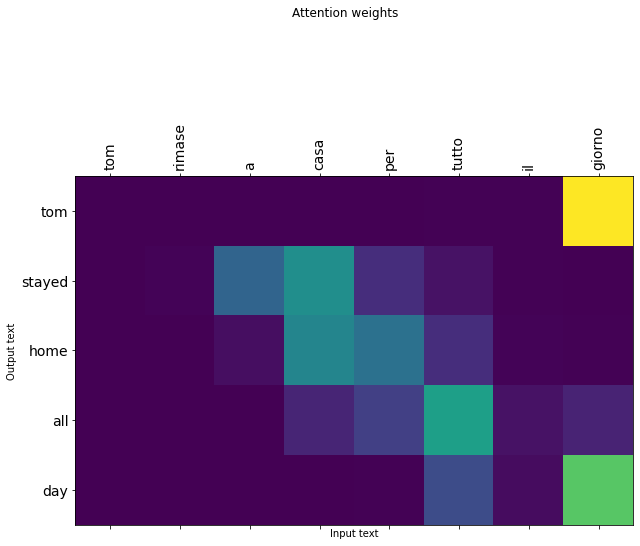

In [ ]:
print('italian sentece------------' ,validation['italian'].iloc[0] )
print('original english sentece---' , validation['english_inp'].iloc[0][8:])
print('predicted english sentece--' , predict(validation['italian'].iloc[0]))


italian sentece------------ io dovevo dire qualcosa
original english sentece--- i had to say something
predicted english sentece--  i had to say something


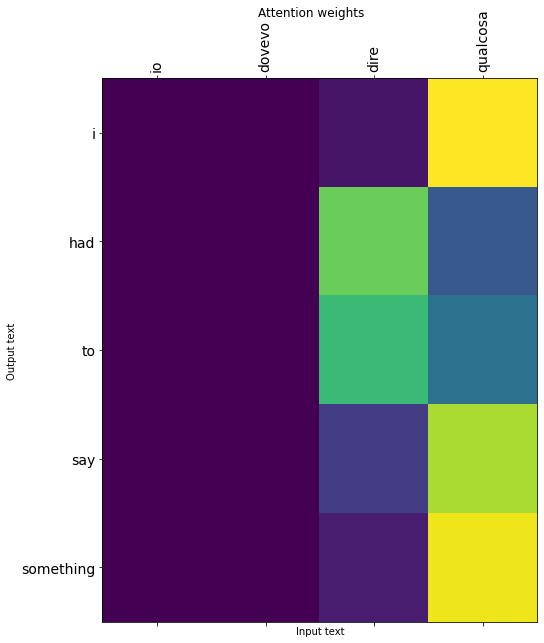

In [ ]:
print('italian sentece------------' ,validation['italian'].iloc[1] )
print('original english sentece---' , validation['english_inp'].iloc[1][8:])
print('predicted english sentece--' , predict(validation['italian'].iloc[1]))

In [ ]:
italian_10 = validation.head(10)['italian']
original_english_10 = validation.head(10)['english_out']
predicted_sentence_10 = []

for italian in italian_10:
  predicted_sentence_10.append(predict(italian))

result_10 = pd.DataFrame({'original' : original_english_10 , 'predicted' : predicted_sentence_10})
result_10

,original,predicted
144180,tom stayed home all day <end>,tom stayed home all day
120500,i had to say something <end>,i had to say something
137797,i want to get rid of it <end>,i want to get rid of it
78480,it is very hot today <end>,there is very hot today
320129,he told his assistant that he would win <end>,he acknowledged his assistant that he would win
218316,i am not one of your soldiers <end>,i am not one of your soldiers
316039,i knew it would happen sooner or later <end>,i knew that would happen sooner later or now
106906,i would like to go faster <end>,i would like to go faster
317803,things are getting out of control here <end>,things are going out out of the way
28335,i am not worried <end>,i am not worried


<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
import nltk.translate.bleu_score as bleu
import random
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

avg_score = 0 
random_values = list(range(0,len(validation)))
random.shuffle(random_values)

for j in range(1000):
  i = random_values[j]
  eng_original = [validation['english_out'].iloc[i].split()[:-1] ]
  italian_original = validation['italian'].iloc[i]
  eng_predict = predict(italian_original).split()

  # score_12gram = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(0.5,0.5))        # since , sentences are small considering only 1-gram and 2-gram
  score = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(1.0,))     
  avg_score += score   

avg_score = avg_score/1000

In [ ]:
avg_score

0.7693846625844933

<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model_general  = encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=25 , score_fun = "general")

optimizer = tf.keras.optimizers.Adam()

model_general.compile(optimizer=optimizer,loss= loss_function)

In [ ]:
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model_general.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps )

Epoch 1/50
276/276 [==============================] - 189s 529ms/step - loss: 0.6753 - val_loss: 0.3900
Epoch 2/50
276/276 [==============================] - 136s 494ms/step - loss: 0.3763 - val_loss: 0.3561
Epoch 3/50
276/276 [==============================] - 137s 495ms/step - loss: 0.3454 - val_loss: 0.3278
Epoch 4/50
276/276 [==============================] - 137s 495ms/step - loss: 0.3177 - val_loss: 0.3013
Epoch 5/50
276/276 [==============================] - 137s 495ms/step - loss: 0.2907 - val_loss: 0.2766
Epoch 6/50
276/276 [==============================] - 137s 496ms/step - loss: 0.2665 - val_loss: 0.2544
Epoch 7/50
276/276 [==============================] - 137s 495ms/step - loss: 0.2448 - val_loss: 0.2347
Epoch 8/50
276/276 [==============================] - 137s 496ms/step - loss: 0.2247 - val_loss: 0.2166
Epoch 9/50
276/276 [==============================] - 137s 495ms/step - loss: 0.2060 - val_loss: 0.1994
Epoch 10/50
276/276 [==============================] - 137s 495m

In [ ]:
model_general.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2758000   
                                                                 
 decoder (Decoder)           multiple                  2760886   
                                                                 
Total params: 5,518,886
Trainable params: 4,210,186
Non-trainable params: 1,308,700
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  sentence , predicted_sentence = sentence.split() , predicted_sentence.split()

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')


<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    sequence_ita = tknizer_ita.texts_to_sequences([input_sentence])
    sequence_ita = pad_sequences(sequence_ita, maxlen=22, dtype='int32', padding='post')
    initial_states = model_general.layers[0].initialize_states(1)               # batch_size , enc_units
    # initial_states = tf.zeros([1 , 100]) , tf.zeros([1 , 100])              # batch_size , enc_units

    enc_outputs,final_state_h , final_state_c =  model_general.layers[0]( sequence_ita , initial_states)


    input_dec = tknizer_eng.word_index['<start>']
    word_index_end = tknizer_eng.word_index['<end>']
    # list_of_attention_weights =  tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    predicted_sentence = ""
    i=0

    for i in range(25):
        output , final_state_h , final_state_c , attention_weights , context_vector = model_general.layers[1].onestepdecoder(tf.cast(tf.reshape(input_dec , [1,1]) , tf.int32) , enc_outputs , final_state_h , final_state_c)
        # print(output.shape)                  # (13086,)
        # print(final_state_h.shape)           # (1, 100)
        # print(final_state_c.shape)           # (1, 100)
        # print(attention_weights.shape)       # (1, 22, 1)
        # print(tf.squeeze(attention_weights).shape)    # (22,)

        # list_of_attention_weights = list_of_attention_weights.write(i,tf.squeeze(attention_weights))
        i+=1

        input_dec = np.argmax(output)
        if input_dec == word_index_end:
            break

        predicted_sentence += " " + tknizer_eng.index_word[input_dec]

    # plot_attention(list_of_attention_weights.stack() , input_sentence , predicted_sentence)
    # print(list_of_attention_weights.stack().shape)

    return predicted_sentence 
    






In [ ]:
ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
ta = ta.write(0, tf.constant([1.0, 2.0]))
ta = ta.write(1,  tf.constant([4.0, 23.0]))
ta = ta.write(2,  tf.constant([19.0, 23.0]))

print(ta.read(0))

print(ta.read(1))

print(ta.read(2))

print(ta.stack())



tf.Tensor([1. 2.], shape=(2,), dtype=float32)
tf.Tensor([ 4. 23.], shape=(2,), dtype=float32)
tf.Tensor([19. 23.], shape=(2,), dtype=float32)
tf.Tensor(
[[ 1.  2.]
 [ 4. 23.]
 [19. 23.]], shape=(3, 2), dtype=float32)


italian sentece------------ tom rimase a casa per tutto il giorno
original english sentece--- tom stayed home all day
predicted english sentece--  tom stayed at all at all day


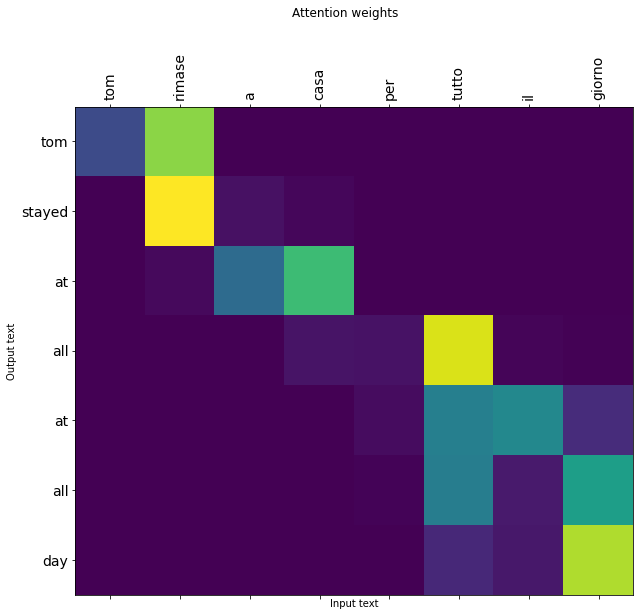

In [ ]:
print('italian sentece------------' ,validation['italian'].iloc[0] )
print('original english sentece---' , validation['english_inp'].iloc[0][8:])
print('predicted english sentece--' , predict(validation['italian'].iloc[0]))


In [ ]:
italian_10 = validation.head(10)['italian']
original_english_10 = validation.head(10)['english_out']
predicted_sentence_10 = []

for italian in italian_10:
  predicted_sentence_10.append(predict(italian))

result_10 = pd.DataFrame({'original' : original_english_10 , 'predicted' : predicted_sentence_10})
result_10

,original,predicted
144180,tom stayed home all day <end>,tom stayed at all at all day
120500,i had to say something <end>,i had to say something
137797,i want to get rid of it <end>,i want to get rid of it
78480,it is very hot today <end>,today is very hot
320129,he told his assistant that he would win <end>,he said his assistant that he would win
218316,i am not one of your soldiers <end>,i am not one of your soldiers
316039,i knew it would happen sooner or later <end>,i knew that would happen to the movie or later
106906,i would like to go faster <end>,i would like to go faster
317803,things are getting out of control here <end>,things are getting out of control here
28335,i am not worried <end>,i am not worried


<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
len(validation)

70767

In [ ]:
import nltk.translate.bleu_score as bleu
import random
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

avg_score = 0 
random_values = list(range(0,len(validation)))
random.shuffle(random_values)

for j in range(1000):
  i = random_values[j]
  eng_original = [validation['english_out'].iloc[i].split()[:-1] ]
  italian_original = validation['italian'].iloc[i]
  eng_predict = predict(italian_original).split()

  # score_12gram = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(0.5,0.5))        # since , sentences are small considering only 1-gram and 2-gram
  score = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(1.0,))     
  avg_score += score   

avg_score = avg_score/1000

In [ ]:
avg_score

0.8018603438599083

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
model_concat  = encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=25 , score_fun = "concat")
optimizer = tf.keras.optimizers.Adam()
model_concat.compile(optimizer=optimizer,loss= loss_function)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'  ,restore_best_weights = True 
)
callbacks = [earlystop ]

In [ ]:
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model_concat.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps ,callbacks = callbacks)

Epoch 1/50
276/276 [==============================] - 209s 595ms/step - loss: 0.6579 - val_loss: 0.3857
Epoch 2/50
276/276 [==============================] - 152s 552ms/step - loss: 0.3736 - val_loss: 0.3564
Epoch 3/50
276/276 [==============================] - 152s 551ms/step - loss: 0.3488 - val_loss: 0.3335
Epoch 4/50
276/276 [==============================] - 152s 552ms/step - loss: 0.3229 - val_loss: 0.3081
Epoch 5/50
276/276 [==============================] - 152s 552ms/step - loss: 0.2972 - val_loss: 0.2829
Epoch 6/50
276/276 [==============================] - 152s 552ms/step - loss: 0.2717 - val_loss: 0.2598
Epoch 7/50
276/276 [==============================] - 153s 553ms/step - loss: 0.2467 - val_loss: 0.2366
Epoch 8/50
276/276 [==============================] - 153s 553ms/step - loss: 0.2226 - val_loss: 0.2153
Epoch 9/50
276/276 [==============================] - 152s 552ms/step - loss: 0.2011 - val_loss: 0.1970
Epoch 10/50
276/276 [==============================] - 152s 552m

In [ ]:
model_concat.summary()

Model: "encoder_decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  2758000   
                                                                 
 decoder_1 (Decoder)         multiple                  2771087   
                                                                 
Total params: 5,529,087
Trainable params: 4,220,387
Non-trainable params: 1,308,700
_________________________________________________________________


In [ ]:
model_concat.save('/content/model_concat')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r /content/model_concat /content/gdrive/MyDrive

In [ ]:
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    sequence_ita = tknizer_ita.texts_to_sequences([input_sentence])
    sequence_ita = pad_sequences(sequence_ita, maxlen=22, dtype='int32', padding='post')
    initial_states = model_concat.layers[0].initialize_states(1)               # batch_size , enc_units
    # initial_states = tf.zeros([1 , 100]) , tf.zeros([1 , 100])              # batch_size , enc_units

    enc_outputs,final_state_h , final_state_c =  model_concat.layers[0]( sequence_ita , initial_states)


    input_dec = tknizer_eng.word_index['<start>']
    word_index_end = tknizer_eng.word_index['<end>']
    # list_of_attention_weights =  tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    predicted_sentence = ""
    i=0

    for i in range(25):
        output , final_state_h , final_state_c , attention_weights , context_vector = model_concat.layers[1].onestepdecoder(tf.cast(tf.reshape(input_dec , [1,1]) , tf.int32) , enc_outputs , final_state_h , final_state_c)
        # print(output.shape)                  # (13086,)
        # print(final_state_h.shape)           # (1, 100)
        # print(final_state_c.shape)           # (1, 100)
        # print(attention_weights.shape)       # (1, 22, 1)
        # print(tf.squeeze(attention_weights).shape)    # (22,)

        # list_of_attention_weights = list_of_attention_weights.write(i,tf.squeeze(attention_weights))
        i+=1

        input_dec = np.argmax(output)
        if input_dec == word_index_end:
            break

        predicted_sentence += " " + tknizer_eng.index_word[input_dec]

    # plot_attention(list_of_attention_weights.stack() , input_sentence , predicted_sentence)
    # print(list_of_attention_weights.stack().shape)

    return predicted_sentence 
    






In [ ]:
ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
ta = ta.write(0, tf.constant([1.0, 2.0]))
ta = ta.write(1,  tf.constant([4.0, 23.0]))
ta = ta.write(2,  tf.constant([19.0, 23.0]))

print(ta.read(0))

print(ta.read(1))

print(ta.read(2))

print(ta.stack())



tf.Tensor([1. 2.], shape=(2,), dtype=float32)
tf.Tensor([ 4. 23.], shape=(2,), dtype=float32)
tf.Tensor([19. 23.], shape=(2,), dtype=float32)
tf.Tensor(
[[ 1.  2.]
 [ 4. 23.]
 [19. 23.]], shape=(3, 2), dtype=float32)


In [ ]:
print('italian sentece------------' ,validation['italian'].iloc[0] )
print('original english sentece---' , validation['english_inp'].iloc[0][8:])
print('predicted english sentece--' , predict(validation['italian'].iloc[0]))


italian sentece------------ tom rimase a casa per tutto il giorno
original english sentece--- tom stayed home all day
predicted english sentece--  tom stayed home for the moment day


In [ ]:
italian_10 = validation.head(10)['italian']
original_english_10 = validation.head(10)['english_out']
predicted_sentence_10 = []

for italian in italian_10:
  predicted_sentence_10.append(predict(italian))

result_10 = pd.DataFrame({'original' : original_english_10 , 'predicted' : predicted_sentence_10})
result_10

,original,predicted
144180,tom stayed home all day <end>,tom stayed home for the moment day
120500,i had to say something <end>,i had to say something
137797,i want to get rid of it <end>,i want to get rid of it
78480,it is very hot today <end>,today is very warm
320129,he told his assistant that he would win <end>,he told his assistant that he would win
218316,i am not one of your soldiers <end>,i am not one of your soldiers
316039,i knew it would happen sooner or later <end>,i knew it would happen sooner or
106906,i would like to go faster <end>,i wish i to get faster
317803,things are getting out of control here <end>,things are going out of control out
28335,i am not worried <end>,i am not worried


<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
import nltk.translate.bleu_score as bleu
import random
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

avg_score = 0 
random_values = list(range(0,len(validation)))
random.shuffle(random_values)

for j in range(1000):
  i = random_values[j]
  eng_original = [validation['english_out'].iloc[i].split()[:-1] ]
  italian_original = validation['italian'].iloc[i]
  eng_predict = predict(italian_original).split()

  # score_12gram = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(0.5,0.5))        # since , sentences are small considering only 1-gram and 2-gram
  score = bleu.sentence_bleu(eng_original, eng_predict ,  weights=(1.0,))     
  avg_score += score   

avg_score = avg_score/1000